# Web Server Performance Analysis: Apache vs Nginx

## NSPNAO2025 Lab Week 05 - Performance Evaluation

This notebook performs comprehensive statistical analysis and visualization of Apache and Nginx web server performance under different resource constraints and concurrent user loads.

### Experimental Design:
- **Scenario A**: 0.5 CPU cores, 512MB RAM
- **Scenario B**: 1.0 CPU core, 512MB RAM
- **Load Levels**: 100, 500, 1000, 2500, 5000 VUs (Virtual Users)
- **Duration**: 120 seconds per test (30s ramp-up, 60s steady state, 30s ramp-down)

## 1. Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
import warnings

warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Data Loading Functions

In [2]:
def load_k6_csv(file_path):
    """
    Load k6 CSV results file.
    
    Args:
        file_path: Path to k6 CSV file
        
    Returns:
        DataFrame with k6 metrics
    """
    df = pd.read_csv(file_path)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    return df

def parse_summary_file(file_path):
    """
    Parse k6 summary text file to extract key metrics.
    
    Args:
        file_path: Path to summary text file
        
    Returns:
        Dictionary with parsed metrics
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()
    
    metrics = {}
    
    # Extract http_req_duration metrics
    if 'http_req_duration' in content:
        line = [l for l in content.split('\n') if 'http_req_duration' in l and 'avg=' in l][0]
        parts = line.split()
        for part in parts:
            if 'avg=' in part:
                metrics['avg_duration'] = parse_duration(part.split('=')[1])
            elif 'p(95)=' in part:
                metrics['p95_duration'] = parse_duration(part.split('=')[1])
            elif 'p(90)=' in part:
                metrics['p90_duration'] = parse_duration(part.split('=')[1])
            elif 'max=' in part:
                metrics['max_duration'] = parse_duration(part.split('=')[1])
            elif 'min=' in part:
                metrics['min_duration'] = parse_duration(part.split('=')[1])
            elif 'med=' in part:
                metrics['med_duration'] = parse_duration(part.split('=')[1])
    
    # Extract http_reqs (throughput)
    if 'http_reqs' in content:
        line = [l for l in content.split('\n') if l.strip().startswith('http_reqs')][0]
        parts = line.split()
        if len(parts) >= 3:
            metrics['total_requests'] = int(parts[1])
            metrics['throughput'] = float(parts[2].replace('/s', ''))
    
    # Extract http_req_failed (error rate)
    if 'http_req_failed' in content:
        line = [l for l in content.split('\n') if l.strip().startswith('http_req_failed')][0]
        parts = line.split()
        if len(parts) >= 2:
            metrics['error_rate'] = float(parts[1].replace('%', '').replace(':', ''))
    
    # Extract checks
    if 'checks_succeeded' in content:
        line = [l for l in content.split('\n') if 'checks_succeeded' in l][0]
        parts = line.split()
        if len(parts) >= 2:
            metrics['checks_success_rate'] = float(parts[1].replace('%', '').replace(':', ''))
    
    return metrics

def parse_duration(duration_str):
    """
    Parse duration string from k6 output (e.g., '1.16ms', '2s', '31.29ms').
    
    Args:
        duration_str: Duration string
        
    Returns:
        Duration in milliseconds
    """
    duration_str = duration_str.strip()
    
    if 'ms' in duration_str:
        return float(duration_str.replace('ms', ''))
    elif 'µs' in duration_str or 'us' in duration_str:
        return float(duration_str.replace('µs', '').replace('us', '')) / 1000
    elif 'm' in duration_str:
        (minute, may_be_seconds) = duration_str.split("m")
        if not may_be_seconds:
            return float(minute) * 60
        return float(minute) * 60 + float(may_be_seconds[:-1])
    elif 's' in duration_str:
        return float(duration_str.replace('s', '')) * 1000
    elif 'µ' in duration_str:
        return float(duration_str.replace('µ', '')) / 1000
    else:
        return float(duration_str)

print("Data loading functions defined!")

Data loading functions defined!


## 3. Load All Test Results

In [3]:
# Define test parameters
results_dir = Path('results')
cpu_scenarios = ['cpu_0.5', 'cpu_1.0']
vu_levels = [100, 500, 1000, 2500, 5000]
servers = ['apache', 'nginx']

# Load all CSV data and calculate statistics from individual request measurements
all_results = []

for cpu_scenario in cpu_scenarios:
    cpu_limit = float(cpu_scenario.replace('cpu_', ''))
    
    for vus in vu_levels:
        vus_dir = results_dir / cpu_scenario / f'vus_{vus}'
        
        for server in servers:
            # Look for CSV files with pattern: {server}_{cpu}_{vus}.csv
            csv_pattern = f'{server}_{cpu_limit}_{vus}.csv'
            csv_file = vus_dir / csv_pattern
            
            if csv_file.exists():
                try:
                    # Load CSV file
                    df_raw = load_k6_csv(csv_file)
                    
                    # Extract http_req_duration measurements (individual request response times)
                    duration_data = df_raw[df_raw['metric_name'] == 'http_req_duration']['metric_value']
                    
                    # Extract http_req_failed measurements (for error rate)
                    failed_data = df_raw[df_raw['metric_name'] == 'http_req_failed']['metric_value']
                    
                    # Calculate test duration (max timestamp - min timestamp)
                    test_duration = (df_raw['timestamp'].max() - df_raw['timestamp'].min()).total_seconds()
                    
                    # Calculate statistics from raw measurements
                    if len(duration_data) > 0:
                        metrics = {
                            'server': server,
                            'cpu_limit': cpu_limit,
                            'vus': vus,
                            'scenario': f'{cpu_limit} CPU',
                            'avg_duration': duration_data.mean(),
                            'std_duration': duration_data.std(),
                            'min_duration': duration_data.min(),
                            'max_duration': duration_data.max(),
                            'med_duration': duration_data.median(),
                            'p90_duration': duration_data.quantile(0.90),
                            'p95_duration': duration_data.quantile(0.95),
                            'p99_duration': duration_data.quantile(0.99),
                            'total_requests': len(duration_data),
                            'throughput': len(duration_data) / test_duration if test_duration > 0 else 0,
                            'error_rate': (failed_data.sum() / len(failed_data) * 100) if len(failed_data) > 0 else 0,
                        }
                        all_results.append(metrics)
                        
                except Exception as e:
                    print(f"Error loading {csv_file}: {e}")
            else:
                print(f"Warning: CSV file not found: {csv_file}")

# Create DataFrame
df_results = pd.DataFrame(all_results)

# Display the loaded data
print(f"\nLoaded {len(df_results)} test results from CSV files")
print(f"\nColumns: {', '.join(df_results.columns)}")
print(f"\nData shape: {df_results.shape}")
print(f"\nSample statistics (first test):")
if len(df_results) > 0:
    print(f"  - Requests measured: {df_results.iloc[0]['total_requests']:.0f}")
    print(f"  - Avg duration: {df_results.iloc[0]['avg_duration']:.3f} ms (±{df_results.iloc[0]['std_duration']:.3f})")
    print(f"  - P95 duration: {df_results.iloc[0]['p95_duration']:.3f} ms")
print()
df_results


Loaded 20 test results from CSV files

Columns: server, cpu_limit, vus, scenario, avg_duration, std_duration, min_duration, max_duration, med_duration, p90_duration, p95_duration, p99_duration, total_requests, throughput, error_rate

Data shape: (20, 15)

Sample statistics (first test):
  - Requests measured: 7199
  - Avg duration: 1.165 ms (±1.223)
  - P95 duration: 2.710 ms



,server,cpu_limit,vus,scenario,avg_duration,std_duration,min_duration,max_duration,med_duration,p90_duration,p95_duration,p99_duration,total_requests,throughput,error_rate
0,apache,0.5,100,0.5 CPU,1.164906,1.223432,0.0,31.2917,1.03570,1.84180,2.710010,5.254204,7199,59.991667,0.000000
1,nginx,0.5,100,0.5 CPU,1.044708,0.993546,0.0,22.7937,0.74865,1.71871,2.540885,4.618931,7230,59.262295,0.000000
2,apache,0.5,500,0.5 CPU,0.761393,1.165866,0.0,29.8256,0.52850,1.07510,1.447370,4.135766,36283,299.859504,0.000000
3,nginx,0.5,500,0.5 CPU,0.726490,1.242616,0.0,31.2816,0.52620,1.05090,1.238850,3.798376,36203,299.198347,0.000000
4,apache,0.5,1000,0.5 CPU,0.841698,1.668281,0.0,65.9541,0.52910,1.07910,1.652940,7.613400,72397,593.418033,0.000000
5,nginx,0.5,1000,0.5 CPU,0.802381,1.782607,0.0,60.9119,0.52730,1.05600,1.568400,7.514736,72553,599.611570,0.000000
6,apache,0.5,2500,0.5 CPU,1148.295006,7694.876108,0.0,60051.0369,0.53110,1.51320,3.272680,59998.743235,102440,813.015873,1.292464
7,nginx,0.5,2500,0.5 CPU,0.871297,2.062455,0.0,68.7765,0.52810,1.07880,1.592500,10.856552,181245,1485.614754,0.000000
8,apache,0.5,5000,0.5 CPU,3131.012270,12857.608665,0.0,60015.2270,0.53790,46.74012,39976.427460,59999.383918,112298,825.720588,4.141659
9,nginx,0.5,5000,0.5 CPU,15.966028,93.000230,0.0,1373.2440,0.53500,6.73642,52.104180,545.298328,357589,2931.057377,0.000000


In [4]:
# Check for NaN values in the loaded DataFrame
print("="*100)
print("DATA VALIDATION")
print("="*100)

nan_summary = df_results.isnull().sum()
columns_with_nans = nan_summary[nan_summary > 0]

if len(columns_with_nans) > 0:
    print(f"\n⚠️  Found NaN values in {len(columns_with_nans)} column(s):\n")
    
    for col, count in columns_with_nans.items():
        print(f"   {col}: {count} NaN value(s)")
    
    print("\n📋 Rows with NaN values:")
    print("="*100)
    
    # Show rows with any NaN values
    rows_with_nans = df_results[df_results.isnull().any(axis=1)]
    
    for idx, row in rows_with_nans.iterrows():
        print(f"\n   Row {idx}: {row['server'].upper()} | {row['scenario']} | {row['vus']} VUs")
        nan_cols = row[row.isnull()].index.tolist()
        print(f"   NaN columns: {', '.join(nan_cols)}")
else:
    print("\n✅ No NaN values found in the dataset!")

print(f"\n📊 Data Summary:")
print(f"   - Total configurations loaded: {len(df_results)}")
print(f"   - Total requests analyzed: {df_results['total_requests'].sum():.0f}")
print(f"   - Average requests per test: {df_results['total_requests'].mean():.0f}")
print(f"   - Min requests in a test: {df_results['total_requests'].min():.0f}")
print(f"   - Max requests in a test: {df_results['total_requests'].max():.0f}")

print("\n" + "="*100)

DATA VALIDATION

✅ No NaN values found in the dataset!

📊 Data Summary:
   - Total configurations loaded: 20
   - Total requests analyzed: 1975809
   - Average requests per test: 98790
   - Min requests in a test: 7199
   - Max requests in a test: 361389



## 3a. Data Quality Validation

This section validates that all test result files were parsed correctly and contain complete metrics. It helps identify corrupted or malformed k6 output files.

## 3a. Data Quality Validation

This section validates that all test result CSV files were loaded correctly and analyzes the distribution of measurements across tests.

In [5]:
def calculate_confidence_interval(data, confidence=0.95):
    """
    Calculate confidence interval using Z-distribution (for n > 30).
    Formula: CI = x̄ ± z_(1-α/2) * (s/√n)
    
    Args:
        data: Array of values
        confidence: Confidence level (default 0.95 for 95% CI)
        
    Returns:
        Tuple of (mean, lower_bound, upper_bound, margin_of_error)
    """
    n = len(data)
    if n == 0:
        return np.nan, np.nan, np.nan, np.nan
    
    mean = np.mean(data)
    std = np.std(data, ddof=1)  # Sample standard deviation
    
    if n > 30:
        # Use Z-distribution for large samples
        z_value = stats.norm.ppf((1 + confidence) / 2)
        margin_of_error = z_value * (std / np.sqrt(n))
    else:
        # Use t-distribution for small samples
        t_value = stats.t.ppf((1 + confidence) / 2, n - 1)
        margin_of_error = t_value * (std / np.sqrt(n))
    
    lower_bound = mean - margin_of_error
    upper_bound = mean + margin_of_error
    
    return mean, lower_bound, upper_bound, margin_of_error

# Create summary DataFrame
# Since we calculated statistics from raw CSV data, we can use them directly
# The std values now represent the standard deviation of individual request durations
df_summary = df_results[['server', 'scenario', 'cpu_limit', 'vus', 
                          'avg_duration', 'std_duration', 'p95_duration', 
                          'throughput', 'error_rate', 'total_requests']].copy()

# Rename columns for consistency with visualization code
df_summary = df_summary.rename(columns={
    'avg_duration': 'avg_duration_mean',
    'std_duration': 'avg_duration_std',
    'p95_duration': 'p95_duration_mean',
    'throughput': 'throughput_mean',
    'error_rate': 'error_rate_mean'
})

# Add std for p95_duration (we don't have this from single runs, so set to NaN)
# To get p95 std, we'd need multiple test runs
df_summary['p95_duration_std'] = np.nan
df_summary['throughput_std'] = np.nan
df_summary['error_rate_std'] = np.nan
df_summary['throughput_count'] = 1  # One test run per configuration

print("\nAggregated Metrics Summary:")
print("\nNote: std_duration represents the standard deviation of individual request")
print("      response times within each test (calculated from thousands of requests).")
print("      This is different from std across multiple test runs.\n")
df_summary


Aggregated Metrics Summary:

Note: std_duration represents the standard deviation of individual request
      response times within each test (calculated from thousands of requests).
      This is different from std across multiple test runs.



,server,scenario,cpu_limit,vus,avg_duration_mean,avg_duration_std,p95_duration_mean,throughput_mean,error_rate_mean,total_requests,p95_duration_std,throughput_std,error_rate_std,throughput_count
0,apache,0.5 CPU,0.5,100,1.164906,1.223432,2.710010,59.991667,0.000000,7199,NaN,NaN,NaN,1
1,nginx,0.5 CPU,0.5,100,1.044708,0.993546,2.540885,59.262295,0.000000,7230,NaN,NaN,NaN,1
2,apache,0.5 CPU,0.5,500,0.761393,1.165866,1.447370,299.859504,0.000000,36283,NaN,NaN,NaN,1
3,nginx,0.5 CPU,0.5,500,0.726490,1.242616,1.238850,299.198347,0.000000,36203,NaN,NaN,NaN,1
4,apache,0.5 CPU,0.5,1000,0.841698,1.668281,1.652940,593.418033,0.000000,72397,NaN,NaN,NaN,1
5,nginx,0.5 CPU,0.5,1000,0.802381,1.782607,1.568400,599.611570,0.000000,72553,NaN,NaN,NaN,1
6,apache,0.5 CPU,0.5,2500,1148.295006,7694.876108,3.272680,813.015873,1.292464,102440,NaN,NaN,NaN,1
7,nginx,0.5 CPU,0.5,2500,0.871297,2.062455,1.592500,1485.614754,0.000000,181245,NaN,NaN,NaN,1
8,apache,0.5 CPU,0.5,5000,3131.012270,12857.608665,39976.427460,825.720588,4.141659,112298,NaN,NaN,NaN,1
9,nginx,0.5 CPU,0.5,5000,15.966028,93.000230,52.104180,2931.057377,0.000000,357589,NaN,NaN,NaN,1


## 5. Capacity Curves: Throughput vs Load

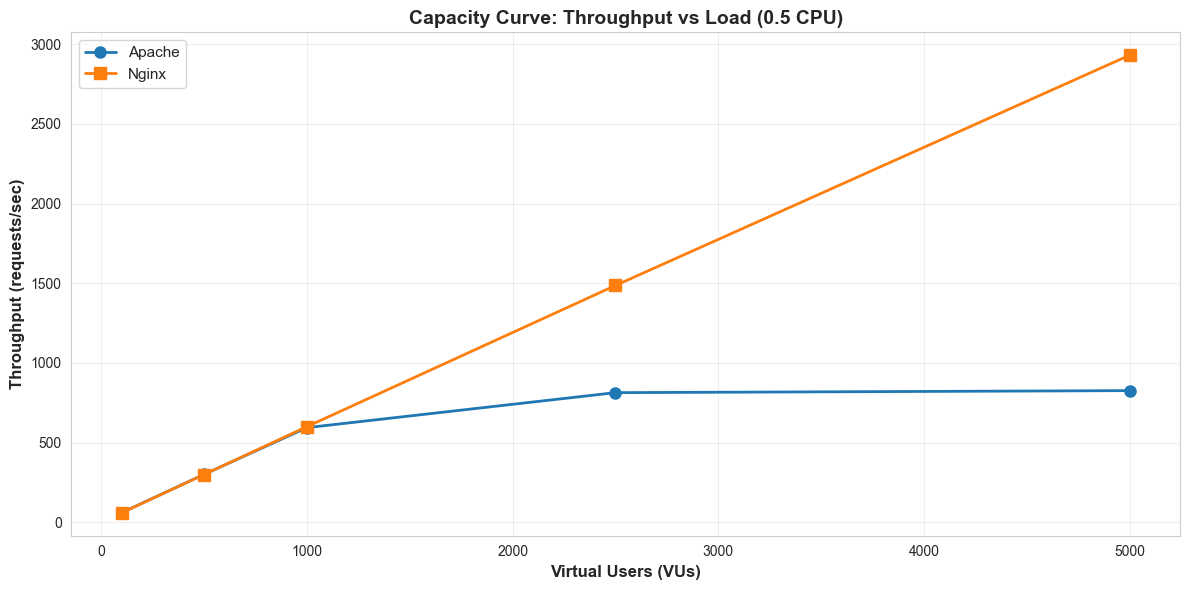

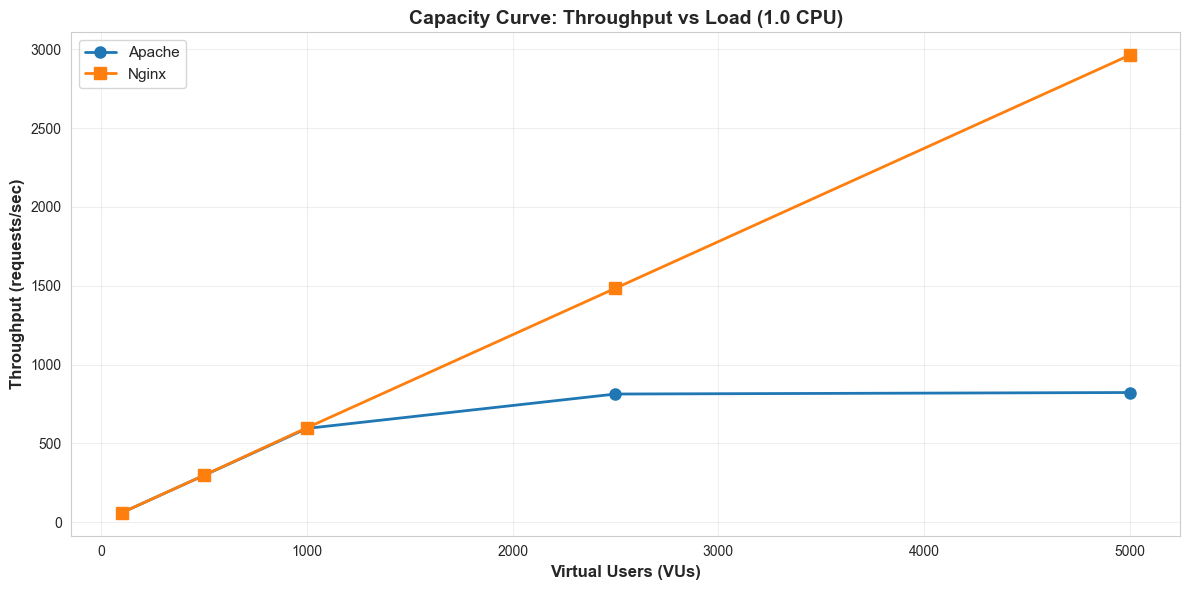

In [6]:
def plot_capacity_curve_throughput(df, cpu_limit):
    """
    Plot throughput vs VUs (load) for capacity analysis.
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    
    scenario_data = df[df['cpu_limit'] == cpu_limit]
    
    for server in ['apache', 'nginx']:
        server_data = scenario_data[scenario_data['server'] == server].sort_values('vus')
        
        x = server_data['vus']
        y = server_data['throughput_mean']
        
        # Plot line
        marker = 'o' if server == 'apache' else 's'
        ax.plot(x, y, marker=marker, linewidth=2, markersize=8, label=server.capitalize())
        
        # Add error bars if std is available
        if 'throughput_std' in server_data.columns:
            yerr = server_data['throughput_std']
            ax.errorbar(x, y, yerr=yerr, fmt='none', alpha=0.3, capsize=5)
    
    ax.set_xlabel('Virtual Users (VUs)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Throughput (requests/sec)', fontsize=12, fontweight='bold')
    ax.set_title(f'Capacity Curve: Throughput vs Load ({cpu_limit} CPU)', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Plot for both scenarios
for cpu in [0.5, 1.0]:
    plot_capacity_curve_throughput(df_summary, cpu)
    plt.show()

## 6. Capacity Curves: Response Time vs Load

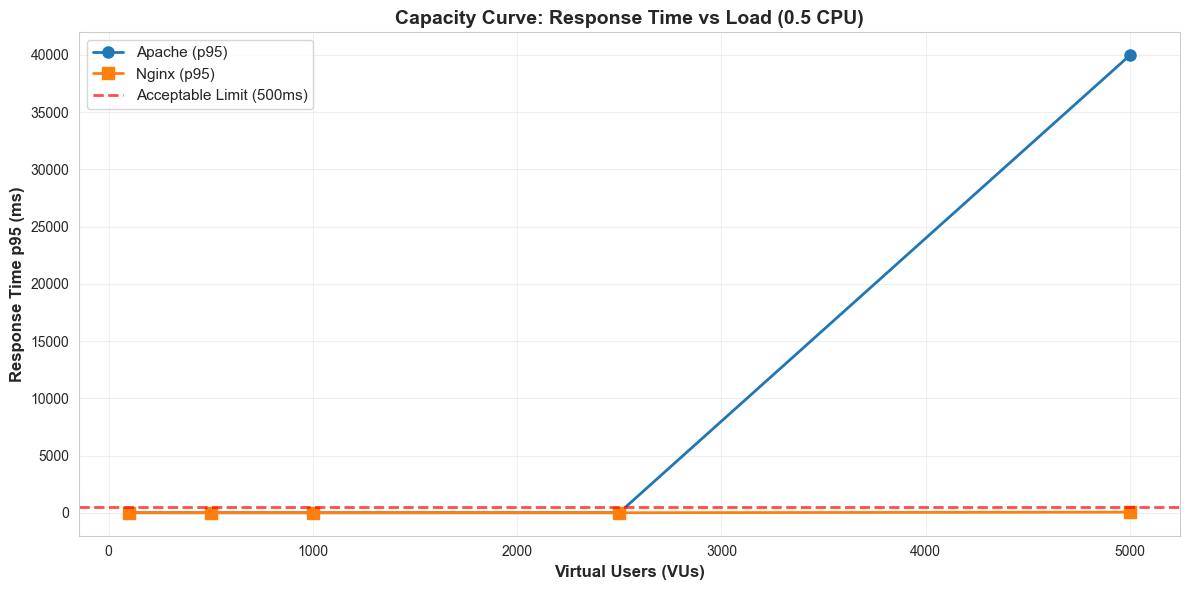

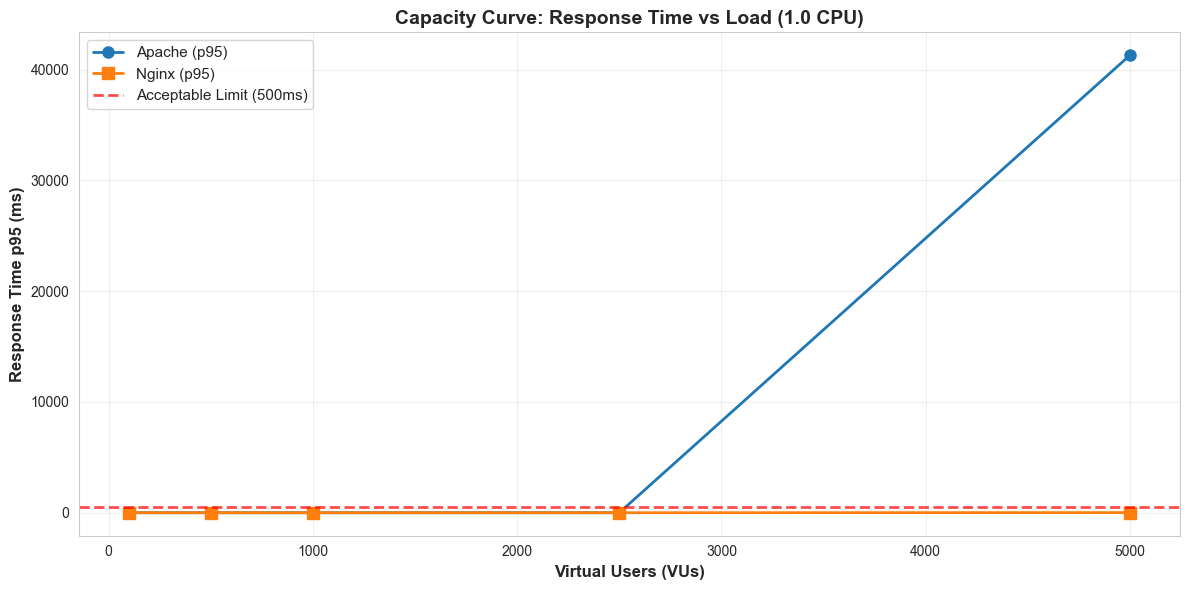

In [7]:
def plot_capacity_curve_response_time(df, cpu_limit, response_time_limit=500):
    """
    Plot response time (p95) vs VUs with acceptable threshold line.
    
    Args:
        df: DataFrame with results
        cpu_limit: CPU limit to filter
        response_time_limit: Acceptable p95 response time threshold in ms
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    
    scenario_data = df[df['cpu_limit'] == cpu_limit]
    
    for server in ['apache', 'nginx']:
        server_data = scenario_data[scenario_data['server'] == server].sort_values('vus')
        
        x = server_data['vus']
        y = server_data['p95_duration_mean']
        
        # Plot line
        marker = 'o' if server == 'apache' else 's'
        ax.plot(x, y, marker=marker, linewidth=2, markersize=8, label=f'{server.capitalize()} (p95)')
        
        # Add error bars if std is available
        if 'p95_duration_std' in server_data.columns:
            yerr = server_data['p95_duration_std']
            ax.errorbar(x, y, yerr=yerr, fmt='none', alpha=0.3, capsize=5)
    
    # Add acceptable threshold line
    ax.axhline(y=response_time_limit, color='red', linestyle='--', linewidth=2, 
               label=f'Acceptable Limit ({response_time_limit}ms)', alpha=0.7)
    
    ax.set_xlabel('Virtual Users (VUs)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Response Time p95 (ms)', fontsize=12, fontweight='bold')
    ax.set_title(f'Capacity Curve: Response Time vs Load ({cpu_limit} CPU)', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Plot for both scenarios
for cpu in [0.5, 1.0]:
    plot_capacity_curve_response_time(df_summary, cpu, response_time_limit=500)
    plt.show()

## 7. Knee Point Detection and Usable Capacity

In [8]:
def find_knee_point(df, server, cpu_limit, response_time_limit=500):
    """
    Find the knee point where throughput plateaus and response time exceeds threshold.
    
    Returns:
        Dictionary with knee point analysis
    """
    server_data = df[(df['server'] == server) & (df['cpu_limit'] == cpu_limit)].sort_values('vus')
    
    if len(server_data) == 0:
        return None
    
    # Find where p95 exceeds threshold
    exceeds_threshold = server_data[server_data['p95_duration_mean'] > response_time_limit]
    
    if len(exceeds_threshold) > 0:
        knee_vus = exceeds_threshold.iloc[0]['vus']
        # Usable capacity is the VU level just before knee point
        usable_capacity_idx = server_data[server_data['vus'] < knee_vus].index
        if len(usable_capacity_idx) > 0:
            usable_capacity = server_data.loc[usable_capacity_idx[-1]]
        else:
            usable_capacity = None
    else:
        knee_vus = None
        usable_capacity = server_data.iloc[-1]  # All loads are acceptable
    
    # Calculate throughput efficiency (throughput per VU)
    server_data['efficiency'] = server_data['throughput_mean'] / server_data['vus']
    
    result = {
        'server': server,
        'cpu_limit': cpu_limit,
        'knee_point_vus': knee_vus,
        'max_throughput': server_data['throughput_mean'].max(),
        'peak_efficiency': server_data['efficiency'].max(),
    }
    
    if usable_capacity is not None:
        result.update({
            'usable_capacity_vus': usable_capacity['vus'],
            'usable_throughput': usable_capacity['throughput_mean'],
            'usable_p95_response': usable_capacity['p95_duration_mean'],
        })
    
    return result

# Find knee points for all configurations
knee_points = []
for cpu in [0.5, 1.0]:
    for server in ['apache', 'nginx']:
        kp = find_knee_point(df_summary, server, cpu, response_time_limit=500)
        if kp:
            knee_points.append(kp)

df_knee_points = pd.DataFrame(knee_points)

print("\n" + "="*80)
print("KNEE POINT ANALYSIS & USABLE CAPACITY")
print("="*80)
df_knee_points


KNEE POINT ANALYSIS & USABLE CAPACITY


,server,cpu_limit,knee_point_vus,max_throughput,peak_efficiency,usable_capacity_vus,usable_throughput,usable_p95_response
0,apache,0.5,5000.0,825.720588,0.599917,2500,813.015873,3.27268
1,nginx,0.5,NaN,2931.057377,0.599612,5000,2931.057377,52.10418
2,apache,1.0,5000.0,822.510949,0.599504,2500,812.913386,5.13211
3,nginx,1.0,NaN,2962.204918,0.598926,5000,2962.204918,15.29590


## 8. Side-by-Side Comparison: Apache vs Nginx


SCENARIO: 0.5 CPU


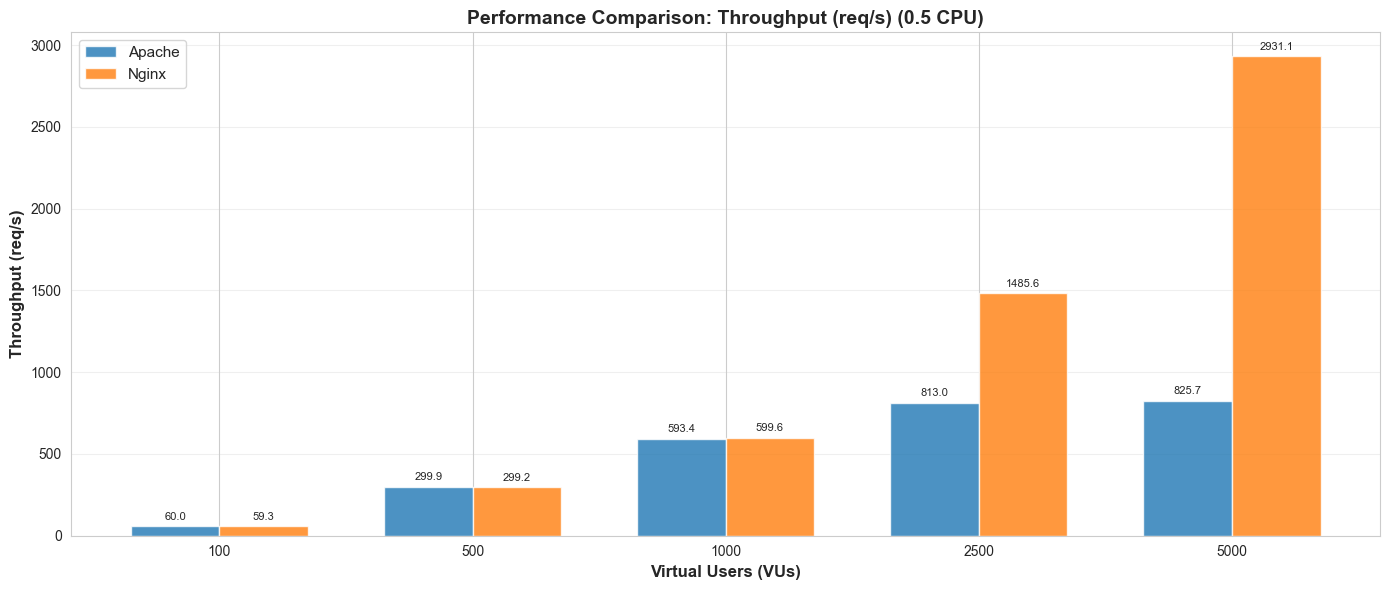

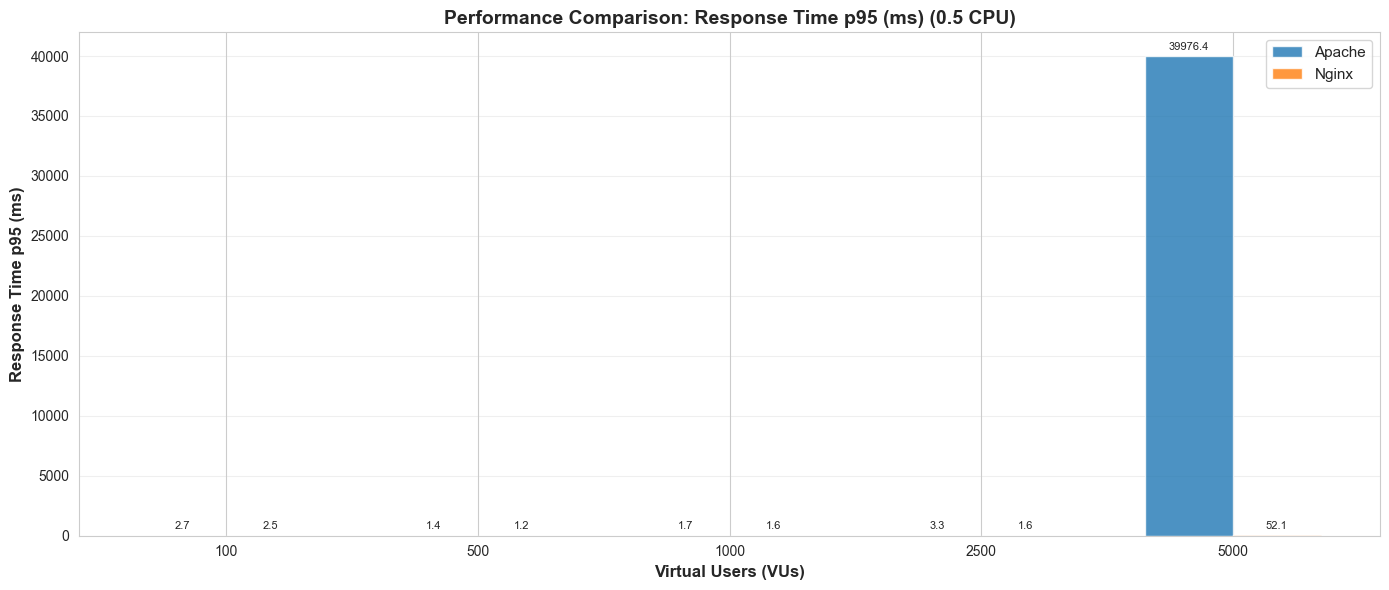

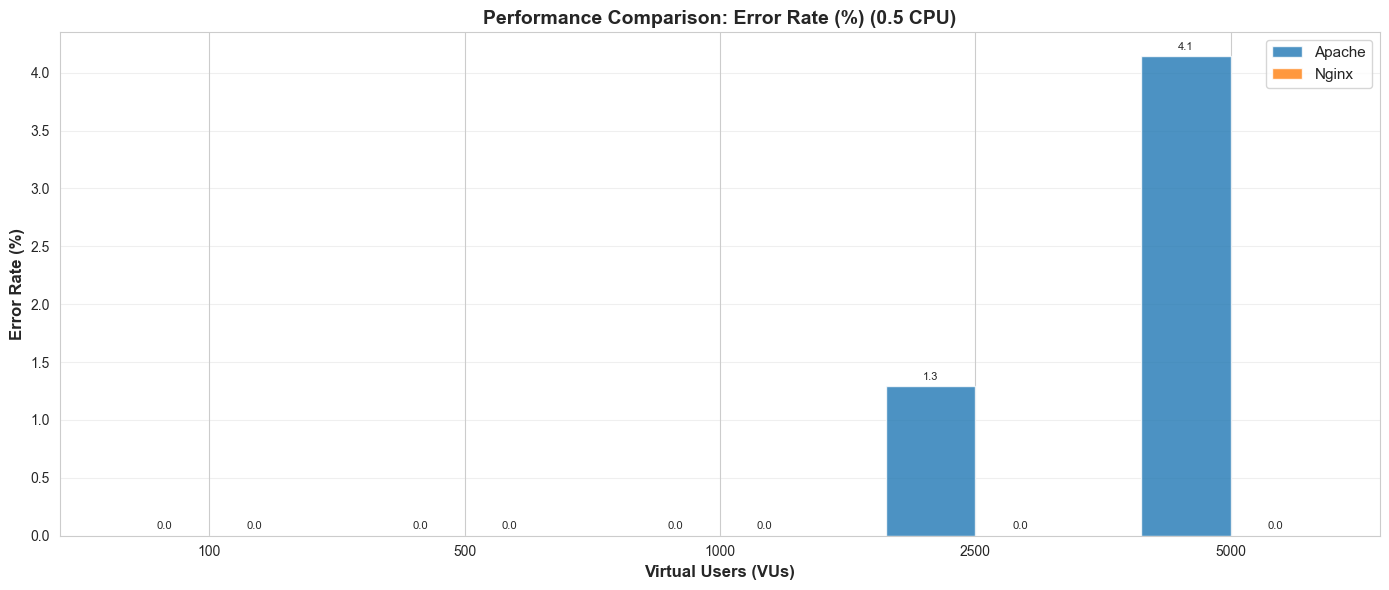


SCENARIO: 1.0 CPU


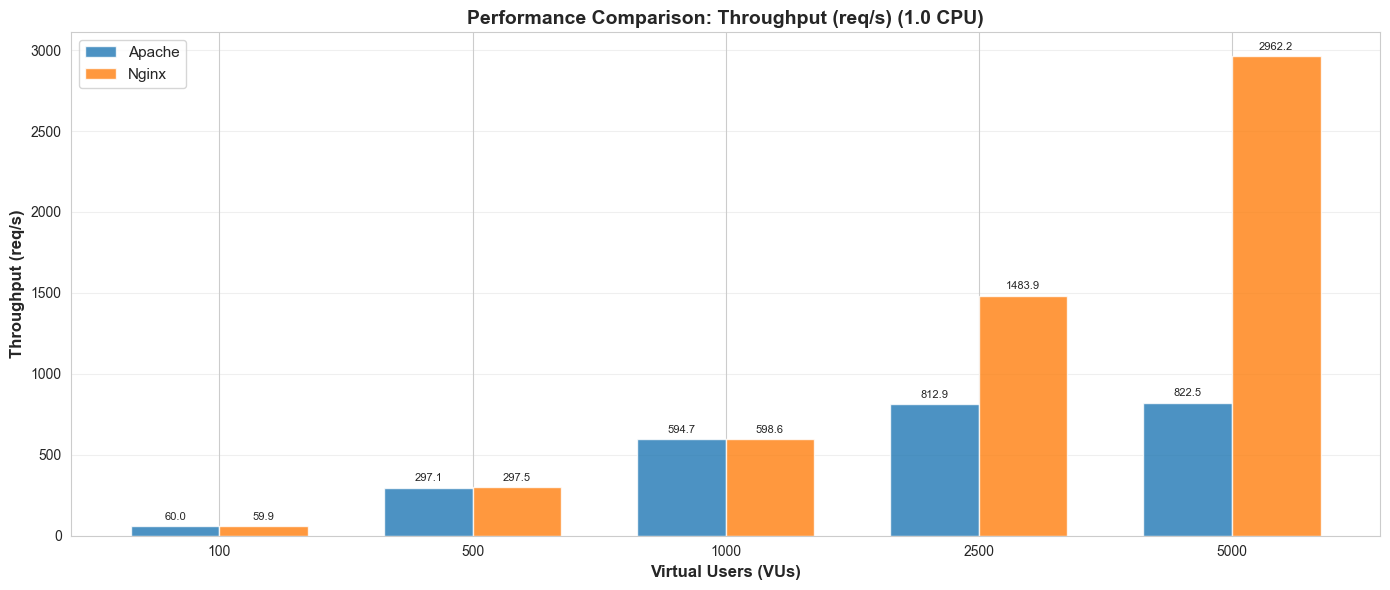

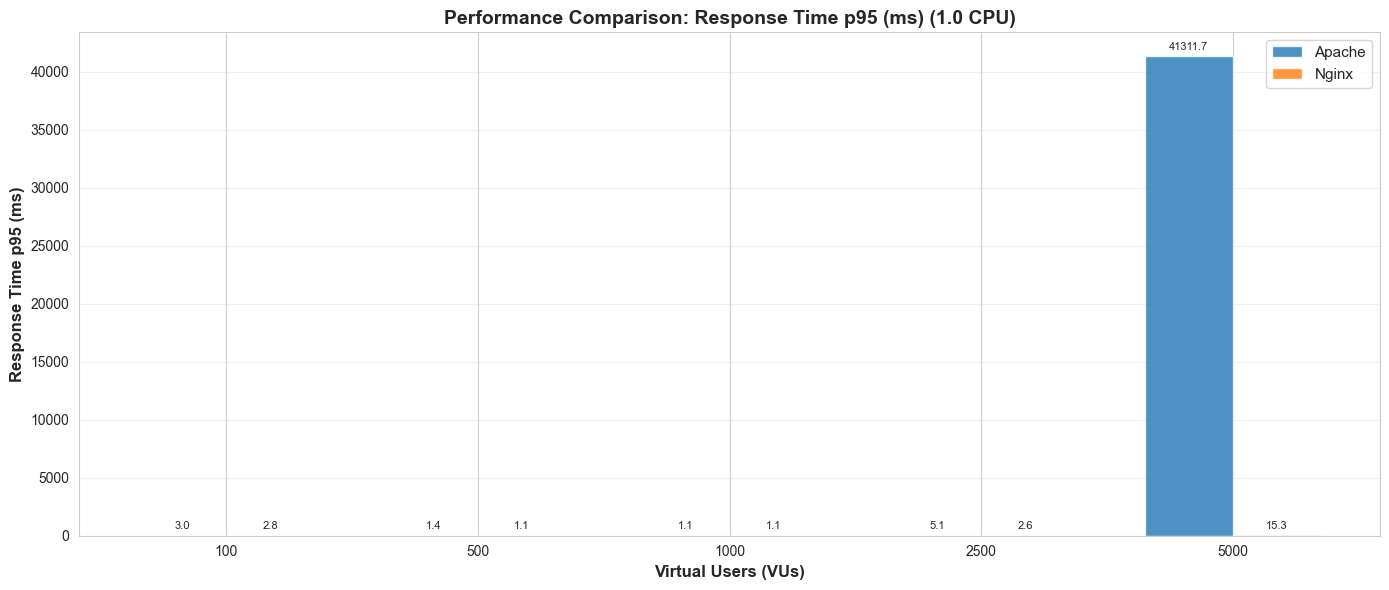

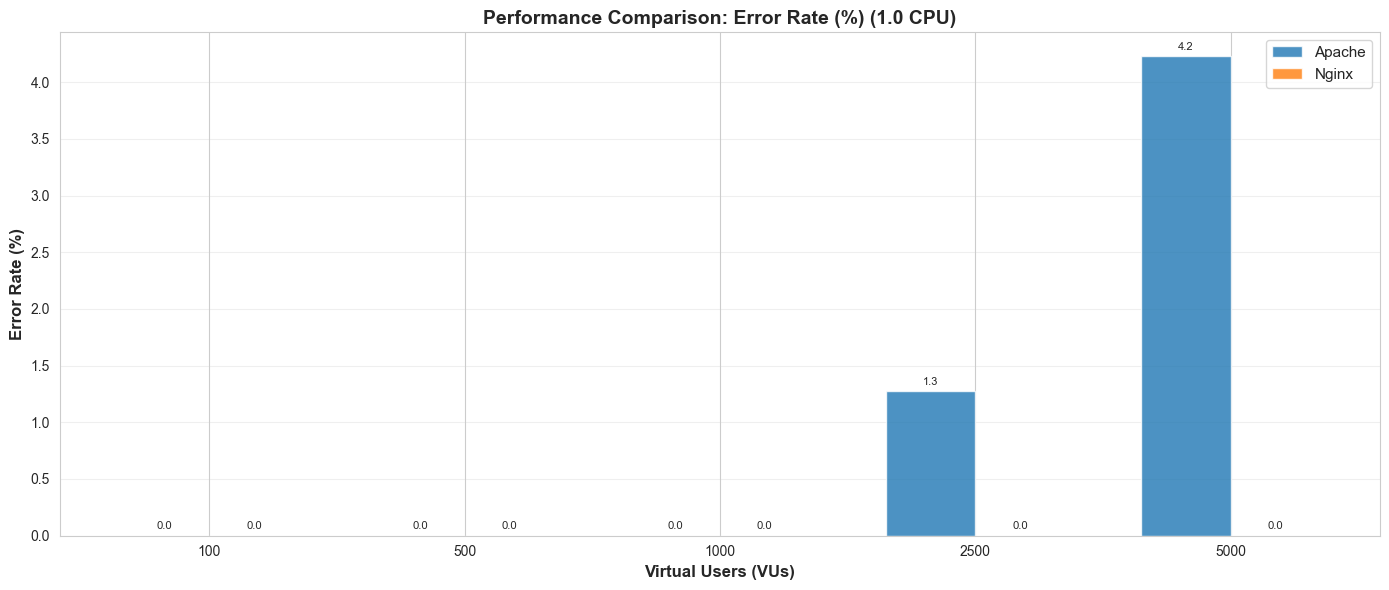

In [9]:
def plot_server_comparison(df, cpu_limit, metric='throughput_mean', ylabel='Throughput (req/s)'):
    """
    Create side-by-side bar chart comparing Apache and Nginx.
    """
    fig, ax = plt.subplots(figsize=(14, 6))
    
    scenario_data = df[df['cpu_limit'] == cpu_limit]
    
    x = np.arange(len(vu_levels))
    width = 0.35
    
    apache_data = scenario_data[scenario_data['server'] == 'apache'].sort_values('vus')
    nginx_data = scenario_data[scenario_data['server'] == 'nginx'].sort_values('vus')
    
    bars1 = ax.bar(x - width/2, apache_data[metric], width, label='Apache', alpha=0.8)
    bars2 = ax.bar(x + width/2, nginx_data[metric], width, label='Nginx', alpha=0.8)
    
    ax.set_xlabel('Virtual Users (VUs)', fontsize=12, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=12, fontweight='bold')
    ax.set_title(f'Performance Comparison: {ylabel} ({cpu_limit} CPU)', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(vu_levels)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.1f}',
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    return fig

# Create comparison charts
for cpu in [0.5, 1.0]:
    print(f"\n{'='*80}")
    print(f"SCENARIO: {cpu} CPU")
    print(f"{'='*80}")
    
    plot_server_comparison(df_summary, cpu, 'throughput_mean', 'Throughput (req/s)')
    plt.show()
    
    plot_server_comparison(df_summary, cpu, 'p95_duration_mean', 'Response Time p95 (ms)')
    plt.show()
    
    plot_server_comparison(df_summary, cpu, 'error_rate_mean', 'Error Rate (%)')
    plt.show()

## 9. Statistical Significance Testing with Confidence Intervals


95% Confidence Intervals - 0.5 CPU


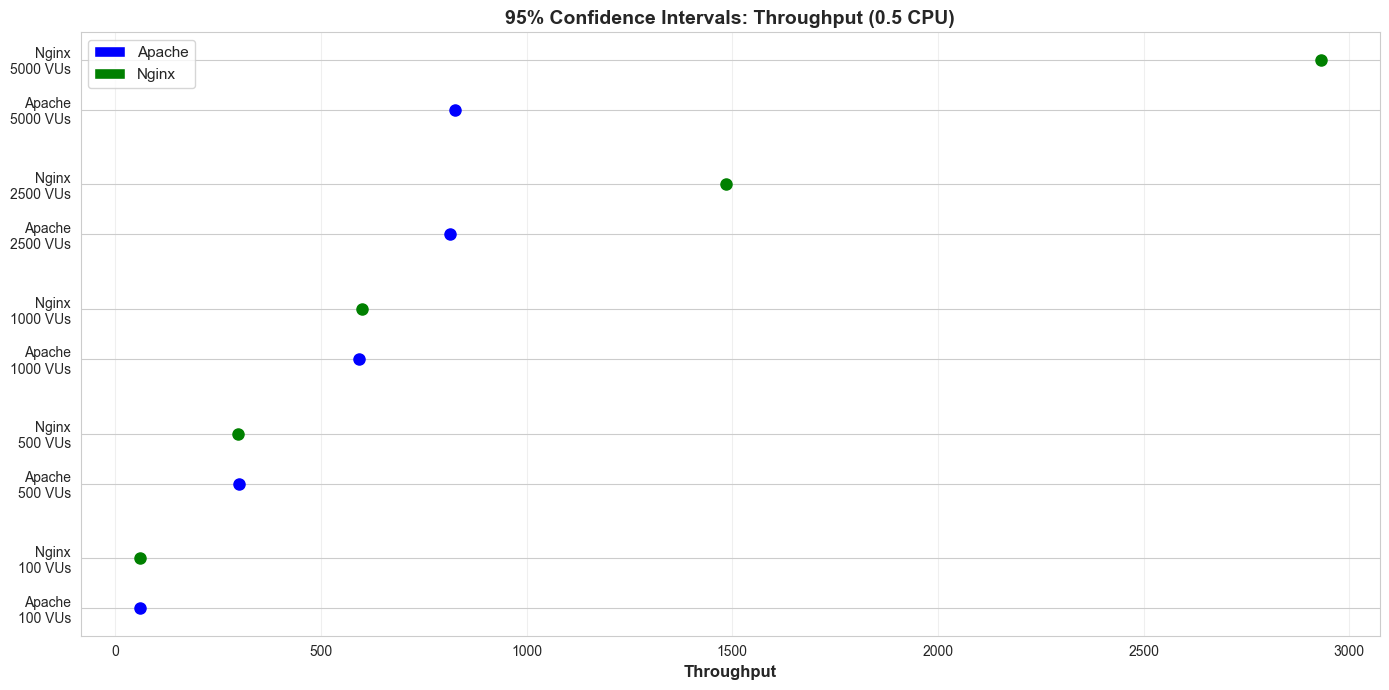

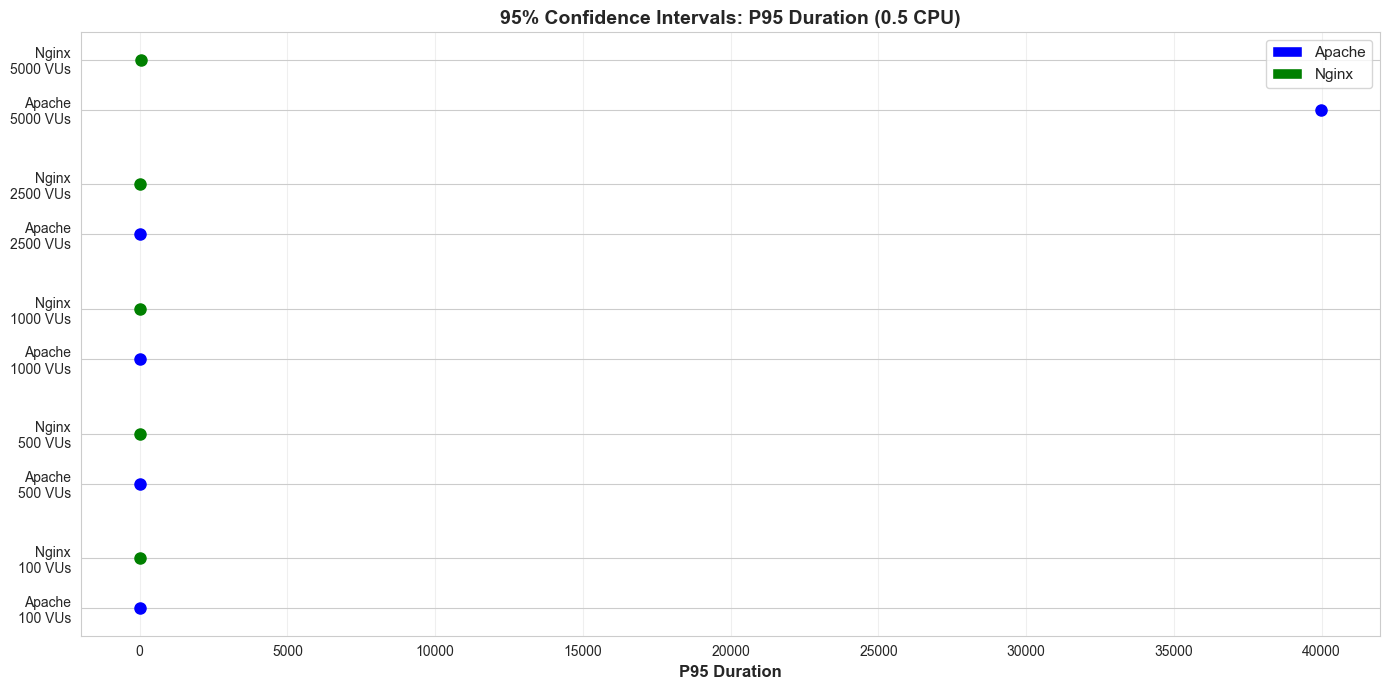


95% Confidence Intervals - 1.0 CPU


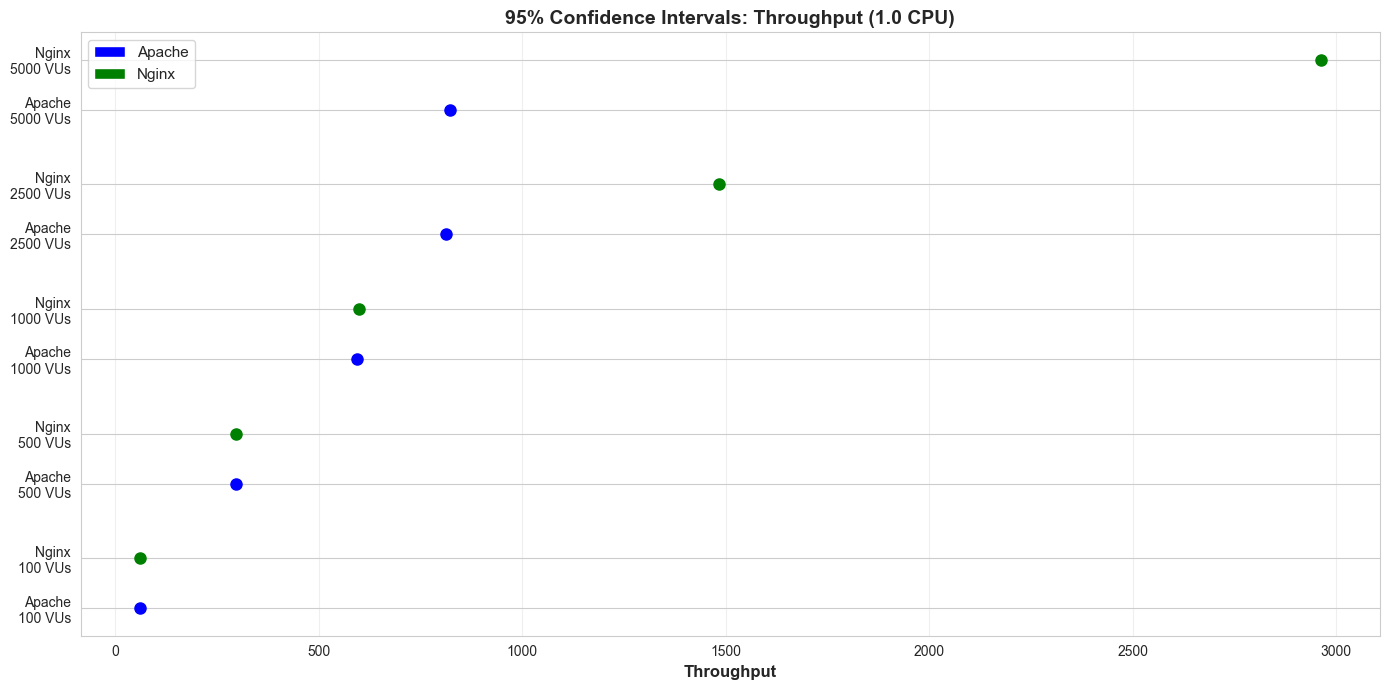

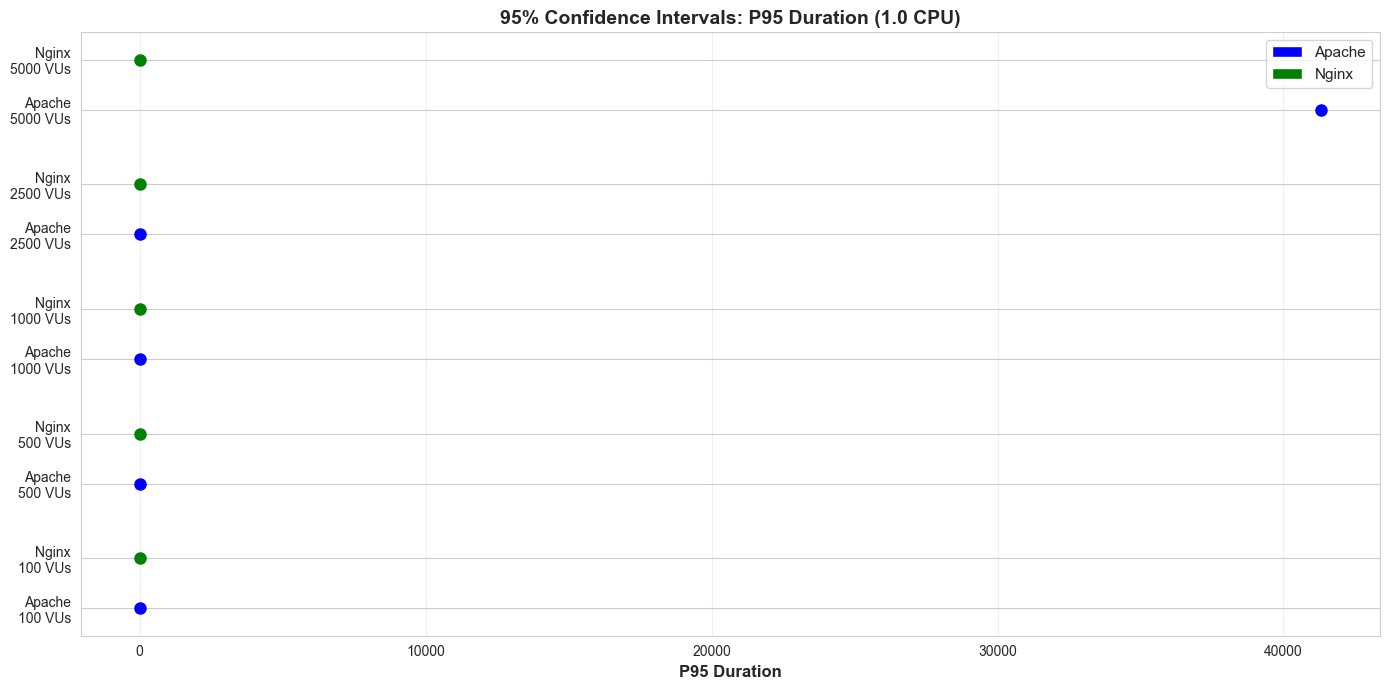

In [10]:
def plot_confidence_intervals(df, cpu_limit, metric='throughput'):
    """
    Plot confidence intervals for visual hypothesis testing.
    Overlapping CIs suggest no significant difference.
    """
    fig, ax = plt.subplots(figsize=(14, 7))
    
    scenario_data = df_results[(df_results['cpu_limit'] == cpu_limit)]
    
    y_pos = 0
    yticks = []
    yticklabels = []
    
    for vus in vu_levels:
        for server in ['apache', 'nginx']:
            data = scenario_data[(scenario_data['vus'] == vus) & (scenario_data['server'] == server)][metric]
            
            if len(data) > 0:
                mean, lower, upper, moe = calculate_confidence_interval(data.values)
                
                color = 'blue' if server == 'apache' else 'green'
                ax.errorbar(mean, y_pos, xerr=[[mean-lower], [upper-mean]], 
                           fmt='o', color=color, capsize=5, capthick=2, markersize=8)
                
                yticks.append(y_pos)
                yticklabels.append(f"{server.capitalize()}\n{vus} VUs")
                y_pos += 1
        
        y_pos += 0.5  # Add spacing between VU groups
    
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.set_xlabel(f'{metric.replace("_", " ").title()}', fontsize=12, fontweight='bold')
    ax.set_title(f'95% Confidence Intervals: {metric.replace("_", " ").title()} ({cpu_limit} CPU)', 
                fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='blue', label='Apache'),
                      Patch(facecolor='green', label='Nginx')]
    ax.legend(handles=legend_elements, fontsize=11)
    
    plt.tight_layout()
    return fig

# Plot confidence intervals for key metrics
for cpu in [0.5, 1.0]:
    print(f"\n{'='*80}")
    print(f"95% Confidence Intervals - {cpu} CPU")
    print(f"{'='*80}")
    
    if 'throughput' in df_results.columns:
        plot_confidence_intervals(df_results, cpu, 'throughput')
        plt.show()
    
    if 'p95_duration' in df_results.columns:
        plot_confidence_intervals(df_results, cpu, 'p95_duration')
        plt.show()

## 9a. Visual Hypothesis Testing: Mean Response Time with Error Bars

This visualization shows the mean response time for Apache and Nginx servers across different load levels, with error bars representing the 95% confidence interval of the mean. Non-overlapping error bars suggest statistically significant differences between the servers at that load level.


VISUAL HYPOTHESIS TESTING: MEAN RESPONSE TIME

Error bars represent 95% confidence interval of the mean (±1.96 × SE)
SE (Standard Error) = std / sqrt(n), where n is the number of requests measured

Interpretation:
  - Non-overlapping error bars → Statistically significant difference
  - Overlapping error bars → No significant difference at 95% confidence level
[ 100  500 1000 2500 5000] [1.16490583e+00 7.61393405e-01 8.41698139e-01 1.14829501e+03
 3.13101227e+03] [2.82618062e-02 1.19964575e-02 1.21524786e-02 4.71219136e+01
 7.52021512e+01]
[ 100  500 1000 2500 5000] [ 1.04470816  0.72648973  0.80238127  0.87129671 15.9660275 ] [0.02290208 0.01280032 0.01297131 0.00949527 0.3048232 ]
[ 100  500 1000 2500 5000] [1.28039574e+00 7.62298598e-01 7.23928248e-01 1.13591398e+03
 3.17766718e+03] [2.07098007e-02 1.13495996e-02 9.29958342e-03 4.66383614e+01
 7.58206849e+01]
[ 100  500 1000 2500 5000] [1.22371693 0.67906633 0.71775184 1.26220941 4.10801391] [0.01999124 0.00927328 0.00953185 0.0181

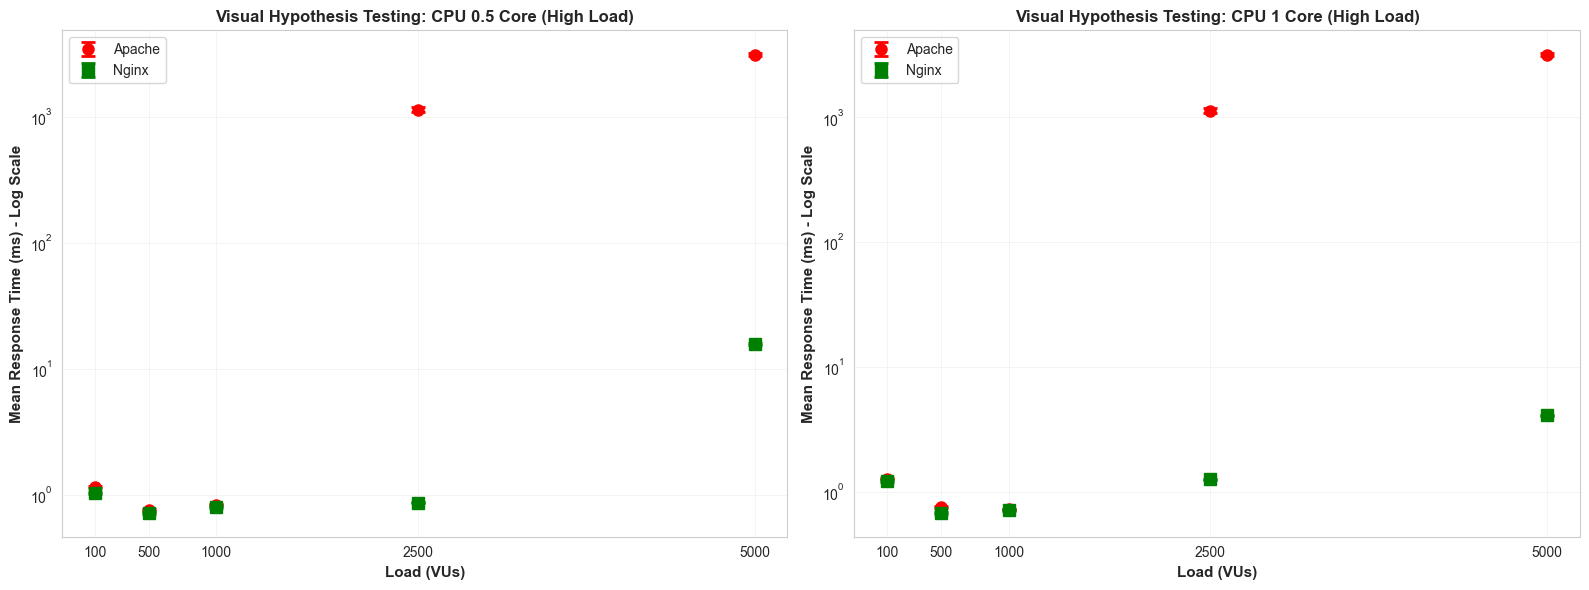

In [16]:
def plot_mean_response_time_with_error_bars():
    """
    Create error bar plots for mean response time comparison between Apache and Nginx.
    Shows 95% confidence interval of the mean for visual hypothesis testing.
    
    Error bars represent: mean ± 1.96 * (std / sqrt(n))
    where n is the number of requests measured.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    cpu_scenarios = [
        (0.5, 'Visual Hypothesis Testing: CPU 0.5 Core (High Load)'),
        (1.0, 'Visual Hypothesis Testing: CPU 1 Core (High Load)')
    ]
    
    for idx, (cpu_limit, title) in enumerate(cpu_scenarios):
        ax = axes[idx]
        
        # Filter data for this CPU scenario
        scenario_data = df_results[df_results['cpu_limit'] == cpu_limit].sort_values(['server', 'vus'])
        
        # Separate data for each server
        apache_data = scenario_data[scenario_data['server'] == 'apache'].sort_values('vus')
        nginx_data = scenario_data[scenario_data['server'] == 'nginx'].sort_values('vus')
        
        # Calculate 95% confidence interval for mean
        # CI = mean ± 1.96 * (std / sqrt(n))
        # Using z-value for 95% CI
        z_value = 1.96
        
        # Apache calculations
        apache_vus = apache_data['vus'].values
        apache_mean = apache_data['avg_duration'].values
        apache_std = apache_data['std_duration'].values
        apache_n = apache_data['total_requests'].values
        apache_ci = z_value * (apache_std / np.sqrt(apache_n))
        
        # Nginx calculations
        nginx_vus = nginx_data['vus'].values
        nginx_mean = nginx_data['avg_duration'].values
        nginx_std = nginx_data['std_duration'].values
        nginx_n = nginx_data['total_requests'].values
        nginx_ci = z_value * (nginx_std / np.sqrt(nginx_n))

        print(apache_vus, apache_mean, apache_ci)
        print(nginx_vus, nginx_mean, nginx_ci)
        
        # Plot error bars
        ax.errorbar(apache_vus, apache_mean, yerr=apache_ci, 
                   fmt='o', color='red', markersize=8, capsize=5, capthick=2,
                   label='Apache', linewidth=2, elinewidth=2)
        
        ax.errorbar(nginx_vus, nginx_mean, yerr=nginx_ci,
                   fmt='s', color='green', markersize=8, capsize=5, capthick=2,
                   label='Nginx', linewidth=2, elinewidth=2)
        
        # Styling
        ax.set_xlabel('Load (VUs)', fontsize=11, fontweight='bold')
        ax.set_ylabel('Mean Response Time (ms)', fontsize=11, fontweight='bold')
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.legend(loc='upper left', fontsize=10)
        ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
        ax.set_facecolor('white')
        
        # Set x-axis ticks
        ax.set_xticks(vu_levels)
        ax.set_xticklabels(vu_levels)
        
        # Set y-axis to start from 0 for better comparison
        # But adjust if values are too large (like at 5000 VUs)
        max_val = max(apache_mean[-1] + apache_ci[-1], nginx_mean[-1] + nginx_ci[-1])
        if max_val > 1000:
            # Use log scale for better visualization when values are very large
            ax.set_yscale('log')
            ax.set_ylabel('Mean Response Time (ms) - Log Scale', fontsize=11, fontweight='bold')
        else:
            ax.set_ylim(bottom=0)
    
    plt.tight_layout()
    return fig

# Create the visualization
print("\n" + "="*100)
print("VISUAL HYPOTHESIS TESTING: MEAN RESPONSE TIME")
print("="*100)
print("\nError bars represent 95% confidence interval of the mean (±1.96 × SE)")
print("SE (Standard Error) = std / sqrt(n), where n is the number of requests measured")
print("\nInterpretation:")
print("  - Non-overlapping error bars → Statistically significant difference")
print("  - Overlapping error bars → No significant difference at 95% confidence level")
print("="*100)

plot_mean_response_time_with_error_bars()
plt.show()

## 10. Performance Summary Table

In [12]:
def create_summary_table(df):
    """
    Create a comprehensive summary table.
    """
    summary = df.pivot_table(
        index=['cpu_limit', 'vus'],
        columns='server',
        values=['throughput_mean', 'p95_duration_mean', 'error_rate_mean'],
        aggfunc='first'
    )
    
    return summary

summary_table = create_summary_table(df_summary)

print("\n" + "="*100)
print("COMPREHENSIVE PERFORMANCE SUMMARY")
print("="*100)
print("\nThroughput (req/s) | Response Time p95 (ms) | Error Rate (%)")
print("="*100)
summary_table


COMPREHENSIVE PERFORMANCE SUMMARY

Throughput (req/s) | Response Time p95 (ms) | Error Rate (%)


error_rate_mean       p95_duration_mean             \
server                  apache nginx            apache      nginx   
cpu_limit vus                                                       
0.5       100         0.000000   0.0           2.71001   2.540885   
          500         0.000000   0.0           1.44737   1.238850   
          1000        0.000000   0.0           1.65294   1.568400   
          2500        1.292464   0.0           3.27268   1.592500   
          5000        4.141659   0.0       39976.42746  52.104180   
1.0       100         0.000000   0.0           3.00476   2.842370   
          500         0.000000   0.0           1.42735   1.146620   
          1000        0.000000   0.0           1.10800   1.118600   
          2500        1.272762   0.0           5.13211   2.649060   
          5000        4.229527   0.0       41311.72346  15.295900   

               throughput_mean               
server                  apache        nginx  
cpu_limit vus                                
0.5       100        59.991667    59.262295  
          500       299.859504   299.198347  
          1000      593.418033   599.611570  
          2500      813.015873  1485.614754  
          5000      825.720588  2931.057377  
1.0       100        59.950413    59.892562  
          500       297.065574   297.450820  
          1000      594.729508   598.619835  
          2500      812.913386  1483.909836  
          5000      822.510949  2962.204918

## 11. Key Findings and Recommendations

In [13]:
print("\n" + "="*100)
print("KEY FINDINGS")
print("="*100)

for cpu in [0.5, 1.0]:
    print(f"\n### Scenario: {cpu} CPU Core(s)\n")
    
    scenario_knee = df_knee_points[df_knee_points['cpu_limit'] == cpu]
    
    for _, row in scenario_knee.iterrows():
        server = row['server'].capitalize()
        print(f"**{server}:**")
        print(f"  - Maximum Throughput: {row['max_throughput']:.2f} req/s")
        
        if pd.notna(row.get('knee_point_vus')):
            print(f"  - Knee Point: {row['knee_point_vus']} VUs")
        else:
            print(f"  - Knee Point: Not reached (response time acceptable at all loads)")
        
        if pd.notna(row.get('usable_capacity_vus')):
            print(f"  - Usable Capacity: {row['usable_capacity_vus']} VUs")
            print(f"  - Usable Throughput: {row['usable_throughput']:.2f} req/s")
            print(f"  - Response Time at Capacity: {row['usable_p95_response']:.2f} ms (p95)")
        
        print()

print("\n" + "="*100)
print("RECOMMENDATIONS")
print("="*100)
print("""
1. **Resource Allocation**: Compare the usable capacity between 0.5 and 1.0 CPU scenarios
   to determine the cost-benefit of additional resources.

2. **Server Selection**: Choose the server (Apache vs Nginx) that provides better throughput
   and lower response times at your expected load level.

3. **Capacity Planning**: Deploy enough instances to stay below the knee point with headroom
   for traffic spikes (typically 60-70% of usable capacity).

4. **Performance Monitoring**: Set alerts when p95 response time exceeds 400ms (80% of 500ms
   threshold) to proactively scale before hitting capacity limits.

5. **Load Testing**: Regularly repeat these tests as application code changes, as even small
   modifications can significantly impact performance characteristics.
""")

print("\n" + "="*100)
print("ANALYSIS COMPLETE")
print("="*100)


KEY FINDINGS

### Scenario: 0.5 CPU Core(s)

**Apache:**
  - Maximum Throughput: 825.72 req/s
  - Knee Point: 5000.0 VUs
  - Usable Capacity: 2500 VUs
  - Usable Throughput: 813.02 req/s
  - Response Time at Capacity: 3.27 ms (p95)

**Nginx:**
  - Maximum Throughput: 2931.06 req/s
  - Knee Point: Not reached (response time acceptable at all loads)
  - Usable Capacity: 5000 VUs
  - Usable Throughput: 2931.06 req/s
  - Response Time at Capacity: 52.10 ms (p95)


### Scenario: 1.0 CPU Core(s)

**Apache:**
  - Maximum Throughput: 822.51 req/s
  - Knee Point: 5000.0 VUs
  - Usable Capacity: 2500 VUs
  - Usable Throughput: 812.91 req/s
  - Response Time at Capacity: 5.13 ms (p95)

**Nginx:**
  - Maximum Throughput: 2962.20 req/s
  - Knee Point: Not reached (response time acceptable at all loads)
  - Usable Capacity: 5000 VUs
  - Usable Throughput: 2962.20 req/s
  - Response Time at Capacity: 15.30 ms (p95)


RECOMMENDATIONS

1. **Resource Allocation**: Compare the usable capacity between 0.

## 12. Export Results for Further Analysis

In [14]:
# Export summary tables to CSV
df_summary.to_csv('performance_summary.csv', index=False)
df_knee_points.to_csv('knee_points_analysis.csv', index=False)

print("\nResults exported:")
print("  - performance_summary.csv")
print("  - knee_points_analysis.csv")
print("\nAnalysis complete! Review the visualizations and tables above.")


Results exported:
  - performance_summary.csv
  - knee_points_analysis.csv

Analysis complete! Review the visualizations and tables above.
